In [11]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, concatenate, Permute
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Convolution2D, UpSampling2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras

import matplotlib.pyplot as plt
import matplotlib.cm, matplotlib.colors

import sys

import numpy as np

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
data1 = np.array([1,1])+0.5*np.random.randn(500000,2)
data2 =-np.array([1,1])+0.5*np.random.randn(500000,2)
data  = np.append(data1,data2,axis=0)
data.shape

(1000000, 2)

In [14]:
# we need to shufule the data because if we plot the first half of the samples, it will take the first gaussian
np.random.shuffle(data)

### We can try the effects of diffrent scaler like one of the follwing:

mc = MinMaxScaler()

data = mc.fit_transform(data) << will scale it between 0 and 1

or

mc = StandardScaler() << this has small diffrence than the original scale

data = mc.fit_transform(data)

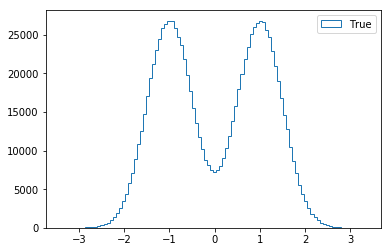

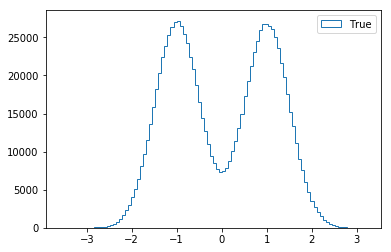

In [15]:
plt.hist(data[:,0], histtype='step', bins = 100)
plt.legend(['True', 'LS-GAN'])
plt.show()

plt.hist(data[:,1], histtype='step', bins = 100)
plt.legend(['True', 'LS-GAN'])
plt.show()

In [16]:
class LSGAN():
    def __init__(self):
        self.img_shape = (2,)
        self.latent_dim = 100
        
        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(z, valid)
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
        self.combined.compile(loss='mse', optimizer=optimizer)
              

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2))
#         model.add(Dense(np.prod(self.img_shape), activation='tanh'))
#         model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def feature_mult(self, x):
        
        return x
    
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.01))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.01))
        # (!!!) No softmax
        model.add(Dense(1))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
                  
        X_train = data
        print(X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        #self.generator.load_weights('ls_generator_gaussian_128k.h5')
        #self.discriminator.load_weights('ls_discriminator_gaussian_128k.h5')
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):

        noise = np.random.normal(0, 1, (100000, 100))

        results = self.generator.predict(noise)
        plt.hist(data[:,0], histtype='step', bins = 100, density=True)
        plt.hist(results[:,0], histtype='step', bins = 100, density=True)
        plt.legend(['True', 'LS-GAN'])
        plt.show()
        
        plt.hist(data[:,1], histtype='step', bins = 100, density=True)
        plt.hist(results[:,1], histtype='step', bins = 100, density=True)
        plt.legend(['True', 'LS-GAN'])
        plt.show()      
        
        plt.hist2d(results[:,0], results[:,1], bins=100, norm = LogNorm())
        plt.show()

In [17]:
gan = LSGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               1536      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total para

In [23]:
# batch size seems to have a great impact, don't know what the optimal is, but I tried 10k
# sample_interval: after which epoch we plot the results.
# because LS-GAN is very fast I don't print the loss for each epoch, if you would like to print the loss, uncomment the following line from the train function:
# print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
gan.train(epochs=5000000, batch_size=10000, sample_interval=5000) 

In [14]:
#save the weights
# gan.generator.save_weights('ls_generator_gaussian_128k.h5')
# gan.discriminator.save_weights('ls_discriminator_gaussian_128k.h5')

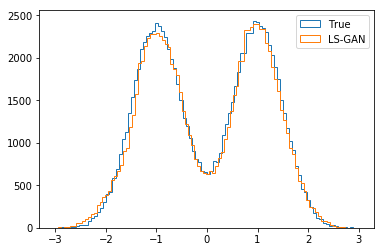

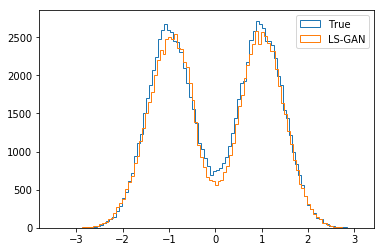

In [23]:
plt.hist(clas[0:100000,0], histtype='step', bins = 100)
plt.hist(results[:,0], histtype='step', bins = 100)
plt.legend(['True', 'LS-GAN'])
plt.show()

plt.hist(clas[0:100000,1], histtype='step', bins = 100)
plt.hist(results[:,1], histtype='step', bins = 100)
plt.legend(['True', 'LS-GAN'])
plt.show()